In [1]:
% f = im2double(imread('circuit.tif'));
% f = im2double(imread('cameraman.tif'));
% f = im2double(imread('lena_face.png'));
f = imread('mbaboon.bmp');

[~,~,dim] = size(f);
if dim == 3     % RGB
    f = rgb2gray(f);
end

f = im2double(f);

In [2]:
sigma = sqrt(2);
len3sig = length(floor(-3*sigma):ceil(3*sigma));
kernel_size = [len3sig len3sig];    % gaussian filter size

%G = fspecial('gaussian',kernel_size,sigma);
[X,Y] = meshgrid(-((kernel_size(1)-1)/2):(kernel_size(1)-1)/2,-((kernel_size(2)-1)/2):(kernel_size(2)-1)/2);
G = exp(-(X.^2+Y.^2)/(2*sigma^2));
G = G./sum(G(:));   % ensure that it sums to 1

% convolution of the image with gaussian filter
fG = conv2(f,G,'same');

In [3]:
Gx = (-X./(sigma^2)) .*G;     % derivative of G w.r.t x
Gy = (-Y./(sigma^2)) .*G;     % derivative of G w.r.t y
% ensure that it sums to 0
Gx = Gx ./ sum(Gx(Gx>0));
Gy = Gy ./ sum(Gy(Gy>0));

% [Gx,Gy] = gradient(G);    % numerical gradient

fx = conv2(f,Gx,'same');
fy = conv2(f,Gy,'same');
% ***************************************
% % Sobel gradient operators
% Sx = [-1 0 1;-2 0 2;-1 0 1];
% Sy = Sx';
% % convolution of the LP filtered image with gradient masks
% fx = conv2(fG,Sx,'same');
% fy = conv2(fG,Sy,'same');
% ******************************************

% compute the gradient magnitude
fM = sqrt(fx.^2+fy.^2);
% compute the angle of gradient
fA = atan2d(fy,fx);

% [Gmag,Gdir] = imgradient(fG);
% figure, imshowpair(Gmag,Gdir,'montage')

% **************** non-maxima suppression ****************
IN = zeros(size(f));    % non-maximum suppressed image
fdir = zeros(size(fA)); % stores the direction of gradient, i.e. 0,45,90,135
for i=2:size(f,1)-1
    for j=2:size(f,2)-1
        % reduce orientations into 4 directions
        if ((fA(i,j)<22.5 && fA(i,j)>-22.5) || (fA(i,j)>157.5 && fA(i,j)<-157.5 ))
            fdir(i,j) = 0;
        elseif ((fA(i,j)>22.5 && fA(i,j)<67.5) || (fA(i,j)>-112.5 && fA(i,j)<-157.5))
            fdir(i,j) = 45;
        elseif ((fA(i,j)>67.5 && fA(i,j)<112.5) || (fA(i,j)>-67.5 && fA(i,j)<-112.5))
            fdir(i,j) = 90;
        elseif ((fA(i,j)>112.5 && fA(i,j)<157.5) || (fA(i,j)>-22.5 && fA(i,j)<-67.5))
            fdir(i,j) = 135;
        end
        
        switch fdir(i,j)
            case 0
                 if fM(i,j) < fM(i,j-1) || fM(i,j) < fM(i,j+1)
                    IN(i,j) = 0;
                else
                    IN(i,j) = fM(i,j);
                end
            case 45
                 if fM(i,j) < fM(i+1,j+1) || fM(i,j) < fM(i-1,j-1)
                    IN(i,j) = 0;
                else
                    IN(i,j) = fM(i,j);
                end
            case 90
                if fM(i,j) < fM(i-1,j) || fM(i,j) < fM(i+1,j)
                    IN(i,j) = 0;
                else
                    IN(i,j) = fM(i,j);
                end
            case 135
                 if fM(i,j) < fM(i-1,j-1) || fM(i,j) < fM(i+1,j+1)
                    IN(i,j) = 0;
                else
                    IN(i,j) = fM(i,j);
                end
        end
        
    end
end

In [4]:
% **************** hysteresis thresholding/edge linking ****************
tl = 0.08;
th = 2*tl;
I1 = IN > tl;
I2 = IN > th;

Ihys = zeros(size(IN));

for i=2:size(f,1)-1
    for j=2:size(f,2)-1
        if I2(i,j) == 1
            Ihys(i,j) = 1;
        else
            if I1(i,j) == 0
                Ihys(i,j) = 0;
            else % 8-CC
                if (I2(i-1,j-1) || I2(i,j-1) || I2(i+1,j-1) || I2(i+1,j) ||...
                        I2(i+1,j+1) || I2(i,j+1) || I2(i-1,j+1) || I2(i-1,j))
                    Ihys(i,j) = 1;
                end         
            end
        end                
    end
end

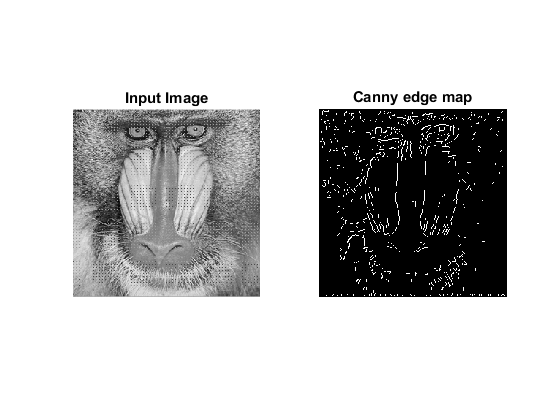

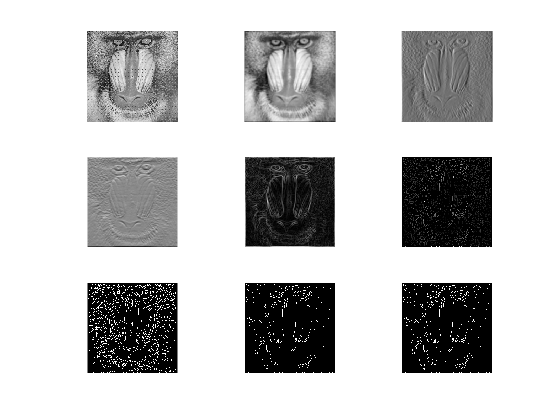

In [5]:

figure,
subplot(331), imshow(f,[]), subplot(332), imshow(fG,[])
subplot(333), imshow(fx,[]), subplot(334), imshow(fy,[])
subplot(335), imshow(fM,[]), subplot(336), imshow(IN,[])
subplot(337), imshow(I1,[]), subplot(338), imshow(I2,[]), 
subplot(339), imshow(Ihys,[])

figure(2)
subplot(1,2,1), imshow(f,[]), title('Input Image')
subplot(1,2,2), imshow(Ihys, []), title('Canny edge map')
